In [1]:
from tqdm import tqdm
import glob
import os
import re
import pandas as pd
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import string
from scipy.sparse import csr_matrix
import numpy as np
import community

In [2]:
def replace_multiple_strings(text, replacements):
    for old_str, new_str in replacements.items():
        text = text.replace(old_str, new_str)
    return text

In [3]:
def read_text(path):
    book = ''
    with open(path, 'r') as f:
        book = f.read()
    return book

In [4]:
def get_all_files(path, extension='.preprocessed'):
    return glob.glob(f"{path}/*{extension}")

In [ ]:
def correct_name(text):
    pattern = r'([A-Z]) \.'
    replacement = r'\1.'
    result_text = re.sub(pattern, replacement, text)
    return result_text

In [5]:
def create_step00():
    folders = [
        'data/les_cavernes_d_acier/',
        'data/prelude_a_fondation/'
    ]
    for folder in tqdm(folders):
        all_files = get_all_files(folder)
        for path in all_files:
            folder_path, file_name  = os.path.split(path)
            folder_path = folder_path.replace('data', 'best')
            new_folder = f'{folder_path}/step00'
            os.makedirs(new_folder, exist_ok=True)
            new_path = f'{new_folder}/{file_name}'
            content = read_text(path)
            content = content.replace('\n', ' ')
            content = re.sub(r'(\w)([.,;!?])', r'\1 \2', content)
            content = re.sub(r'\s+', ' ', content)
            content = correct_name(content)
            
            with open(new_path, 'w') as new_file:
                new_file.write(content)

In [6]:
create_step00()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.93it/s]


In [7]:
def create_step01():
    folders = [
        'best/les_cavernes_d_acier/ner/',
        'best/prelude_a_fondation/ner/'
    ]
    replacements = {'_ner.txt': '.txt.ner', '/ner/':'/step01/'}
    for folder in tqdm(folders):
        all_files = get_all_files(folder, '.txt')
        for path in all_files:
            new_path = replace_multiple_strings(path, replacements)
            new_folder, _  = os.path.split(new_path)
            os.makedirs(new_folder, exist_ok=True)
            with open(new_path, 'w') as new_file:
                new_file.write('name,count\n')
                
            with open(new_path, 'a') as new_file:
                with open(path) as file:
                    lines = file.readlines()
                    for line in lines:
                        parts = line.split(',')
                        parts = [p.strip() for p in parts if len(p.strip()) > 0]
                        for p in parts:
                            new_file.write(f'{p},\n')

In [8]:
create_step01()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 94.98it/s]


In [9]:
def create_step01_count():
    folders = [
        'best/les_cavernes_d_acier/step00/',
        'best/prelude_a_fondation/step00/'
    ]
    replacements = {'/step00/': '/step01/', '.preprocessed':'.ner'}
    for folder in tqdm(folders):
        all_files = get_all_files(folder)
        for path in all_files:
            new_path = replace_multiple_strings(path, replacements)
            with open(path) as file:
                content = file.read()
    
            df = pd.read_csv(new_path)
            df['count'] = df['name'].apply(lambda x: content.count(x))
            df.to_csv(new_path, index=False)

In [10]:
create_step01_count()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 56.93it/s]


In [11]:
def create_step02():
    folders = [
        'best/les_cavernes_d_acier/ner/',
        'best/prelude_a_fondation/ner/'
    ]
    replacements = {'_ner.txt': '.txt.alias', '/ner/':'/step02/'}
    for folder in tqdm(folders):
        all_files = get_all_files(folder, '.txt')
        for path in all_files:
            new_path = replace_multiple_strings(path, replacements)
            new_folder, _  = os.path.split(new_path)
            os.makedirs(new_folder, exist_ok=True)
            with open(new_path, 'w') as new_file:
                new_file.write('code,name,alias\n')
                
            with open(new_path, 'a') as new_file:
                with open(path) as file:
                    lines = file.readlines()
                    for i, line in enumerate(lines, start=1):
                        parts = line.split(',')
                        alias = [p.strip() for p in parts if len(p.strip()) > 0]
                        if len(alias) > 0:
                            alias = sorted(alias, key=len, reverse=True)
                            name = alias[0]
                            code = f'CHAR{i}'
                            new_file.write(f'{code},{name},"{alias}"\n')                            

In [12]:
create_step02()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.74it/s]


In [13]:
pd.read_csv('best/les_cavernes_d_acier/step01/chapter_1.txt.ner')

,name,count
0,Simpson,1
1,R. Sammy,2
2,Vince Barrett,1
3,Vince,2
4,Baley,20
5,Lije,11
6,JULIUS ENDERBY,1
7,Enderby,9
8,Julius,2
9,monsieur le commissaire,6


In [14]:
pd.read_csv('best/les_cavernes_d_acier/step02/chapter_1.txt.alias')

,code,name,alias
0,CHAR1,Simpson,['Simpson']
1,CHAR2,R. Sammy,['R. Sammy']
2,CHAR3,Vince Barrett,"['Vince Barrett', 'Vince']"
3,CHAR4,Baley,"['Baley', 'Lije']"
4,CHAR5,monsieur le commissaire,"['monsieur le commissaire', 'commissaire princ..."
5,CHAR6,Roj Nemennuh Sarton,['Roj Nemennuh Sarton']
6,CHAR7,Jessie,['Jessie']
7,CHAR8,Robot Daneel Olivaw,['Robot Daneel Olivaw']


In [15]:
def replace_ner_by_code(path):
    replacements = {
        "preprocessed": "alias", 
        "step00":"step02"
    }
    with open(path) as file:
        content = file.read()
        
    chapter_alias_path = replace_multiple_strings(path, replacements)
    df_ner = pd.read_csv(chapter_alias_path)
    for i, row in df_ner.iterrows():
        code = row['code']
        alias = eval(row['alias'])
        alias = sorted(alias, key=len, reverse=True)
        for a in alias:
            pattern = re.compile(r'\b{}\b'.format(re.escape(a)), re.IGNORECASE)
            content = pattern.sub(code, content)
            
    with open(path, 'w') as file:
        file.write(content)

In [16]:
def correct_step00_01():
    folders = [
        'best/les_cavernes_d_acier/step00/',
        'best/prelude_a_fondation/step00/'
    ]
    for folder in tqdm(folders):
        all_files = get_all_files(folder)
        for path in all_files:
            replace_ner_by_code(path)

In [17]:
correct_step00_01()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.29it/s]


In [18]:
def remove_punctuation(path):
    with open(path) as file:
        content = file.read()
        
    # Replace punctuaction by space
    puncts = string.punctuation + "’–»«—―‖"
    translator = str.maketrans(puncts, ' ' * len(puncts))
    
    # Use translate to remove punctuation from the text
    content = content.translate(translator)
    content = re.sub(r'\s+', ' ', content)
    with open(path, 'w') as file:
        file.write(content)

In [19]:
def correct_step00_02():
    folders = [
        'best/les_cavernes_d_acier/step00/',
        'best/prelude_a_fondation/step00/'
    ]
    for folder in tqdm(folders):
        all_files = get_all_files(folder)
        for path in all_files:
            remove_punctuation(path)

In [20]:
correct_step00_02()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 31.48it/s]


In [21]:
def generate_idx_dict(path):
    """
    create an idx_dct where the keys are the idx of the names in
    the text and the values are the names
    """
    folder_path, file_name  = os.path.split(path)
    replacements = {
        "preprocessed": "alias", 
        "step00": "step02"
    } 
    alias_path = replace_multiple_strings(path, replacements)
    text = read_text(path)
    names_df = pd.read_csv(alias_path)
    res = dict()
    for i, word in enumerate(text.split(' ')):
        for _,row in names_df.iterrows():
            if word != row['code']:
                continue
            if len(res) > 0:
                last_idx = list(res.keys())[-1]
                if res[last_idx] != row['name']:
                    res[i] = row['name']
                    break
            else:
                res[i] = row['name']
                break
                                
    return res

In [22]:
def find_interactions(idx_dct, N=25):
    res = defaultdict(int)
    names = list(idx_dct.keys())
    
    for i,na in enumerate(names):
        # given an index, get the sublist of all indicies greater than the current index
        if i < len(names) - 1:
            kl = names[i+1:]
        else:
            kl = []
        
        # for each idx greater than the current, check if its found in the range of N
        for k in kl:
            if k-na < N:
                # get names found in current position (na) and index greater than current but in rnage N (k)
                n1 = idx_dct[na]
                n2 = idx_dct[k]
                
                key = tuple(sorted([n1,n2]))
                if n1 != n2:
                    res[key]+=1
    return res

In [23]:
idx_dict = generate_idx_dict('best/les_cavernes_d_acier/step00/chapter_2.txt.preprocessed')

In [24]:
idx_dict

{50: 'Elijah Baley',
 783: 'Julius Enderby',
 799: 'Elijah Baley',
 1843: 'Julius Enderby',
 1887: 'R. Daneel Olivaw',
 1925: 'Elijah Baley',
 1945: 'R. Daneel Olivaw',
 1958: 'Elijah Baley',
 2090: 'R. Daneel Olivaw',
 2108: 'Elijah Baley',
 2258: 'R. Daneel Olivaw',
 2425: 'Elijah Baley',
 2442: 'R. Sammy',
 2510: 'R. Daneel Olivaw',
 2518: 'Elijah Baley',
 2533: 'R. Daneel Olivaw',
 2542: 'Elijah Baley',
 2703: 'R. Daneel Olivaw',
 2723: 'Elijah Baley'}

In [25]:
inter = find_interactions(idx_dict)

In [26]:
inter

defaultdict(int,
            {('Elijah Baley', 'Julius Enderby'): 1,
             ('Elijah Baley', 'R. Daneel Olivaw'): 7,
             ('Elijah Baley', 'R. Sammy'): 1})

In [27]:
def store_interaction(int_dict, path):
    data = []
    for key, weight in int_dict.items():
        data.append((key[0], key[1], weight))
        
    alias_df = pd.DataFrame(data, columns=['source', 'target', 'weight'])

    replacements = {"step00": "step03", "preprocessed": "interact"} 
    alias_path = replace_multiple_strings(path, replacements)

    dirname = os.path.dirname(alias_path)
    os.makedirs(dirname, exist_ok=True)

    alias_df.to_csv(alias_path,  index=False)

In [28]:
def create_step_03():
    paths = [
        'best/les_cavernes_d_acier/step00/', 
        'best/prelude_a_fondation/step00/'
    ]        
    for path in tqdm(paths):
        livre = replace_multiple_strings(path, {'best/':'','/step00/':''})
        print(f"Livre: {livre}")
        all_chapter_path = get_all_files(path)
        for chapter_path in all_chapter_path:
            names_idx = generate_idx_dict(chapter_path)
            int_dict = find_interactions(names_idx)
            store_interaction(int_dict, chapter_path) 

In [29]:
create_step_03()

  0%|                                                                                                                                            | 0/2 [00:00<?, ?it/s]

Livre: les_cavernes_d_acier


 50%|██████████████████████████████████████████████████████████████████                                                                  | 1/2 [00:04<00:04,  4.21s/it]

Livre: prelude_a_fondation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.85s/it]


In [30]:
pd.read_csv('best/les_cavernes_d_acier/step03/chapter_4.txt.interact')

,source,target,weight
0,Julius Enderby,Lije Baley,1
1,Julius Enderby,Jézabel,1
2,Jézabel,Lije Baley,4
3,Jézabel,le mari de Jézabel,3
4,Jéhoram,le mari de Jézabel,1
5,Jéhu,le mari de Jézabel,1
6,Jéhoram,Jézabel,1
7,Jéhu,Jézabel,2
8,Jéhoram,Jéhu,1
9,Jézabel,Naboth,4


In [31]:
def get_id_graph(path):
    file_path, file_name  = os.path.split(path)
    nom_livre = file_path.split('/')[-2]
    code_livre = "lca" if nom_livre == "les_cavernes_d_acier" else "paf"
    num_chap = int((file_name.split('_')[1]).split('.')[0]) - 1
    return f"{code_livre}{num_chap}"

In [32]:
def create_graph(path):
    edges_df = pd.read_csv(path)
    G = nx.from_pandas_edgelist(edges_df, edge_attr = True)
    nodes = list(G.nodes)
    replacements = {"step03": "step02", "interact": "alias"} 
    alias_path = replace_multiple_strings(path, replacements)
    alias_df = pd.read_csv(alias_path)
    for _, row in alias_df.iterrows():
        if row['name'] in nodes:
            names = eval(row['alias'])
            G.nodes[row['name']]['names'] = ";".join(names)
    return G

In [33]:
def create_submission():
    paths = [
        'best/les_cavernes_d_acier/step03/', 
        'best/prelude_a_fondation/step03/'
    ]
        
    graph_dict = {'ID': [], 'graphml': []}
    for path in paths:
        livre = replace_multiple_strings(path, {'best/':'','/step03/':''})
        print(f"Livre: {livre}")
        all_chapter_path = get_all_files(path, ".interact")
        for chapter_path in tqdm(all_chapter_path):
            key_1 = f'{path}chapter_'
            chapitre = replace_multiple_strings(chapter_path, 
                                                {
                                                    key_1:'',
                                                     '.txt.interact':''
                                                })
            graph_dict['ID'].append(get_id_graph(chapter_path))
            G = create_graph(chapter_path)
            graphml = "".join(nx.generate_graphml(G))
            graph_dict['graphml'].append(graphml)
    
    graph_df = pd.DataFrame(graph_dict)
    graph_df.set_index("ID", inplace=True)
    graph_df.to_csv("best/my_submission.csv")

In [34]:
create_submission()

Livre: les_cavernes_d_acier


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 599.48it/s]


Livre: prelude_a_fondation


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 931.14it/s]


In [35]:
def create_graphs():
    paths = [
        'best/les_cavernes_d_acier/step03/', 
        'best/prelude_a_fondation/step03/'
    ]
        
    graph_dict = {'ID': [], 'graphml': []}
    graphs = {}
    for path in paths:
        all_chapter_path = get_all_files(path, ".interact")
        livre = replace_multiple_strings(path, {'best/':'','/step03/':''})
        print(f"Livre: {livre}")
        for chapter_path in all_chapter_path:
            key_1 = f'{path}chapter_'
            chapitre = replace_multiple_strings(chapter_path, 
                                                {
                                                    key_1:'',
                                                     '.txt.interact':''
                                                })
            G = create_graph(chapter_path)
            gid = f'{livre}_{chapitre}'
            graphs[gid] = G       
    return graphs

In [36]:
graphs = create_graphs()

Livre: les_cavernes_d_acier
Livre: prelude_a_fondation


In [37]:
graphs.keys()

dict_keys(['les_cavernes_d_acier_18', 'les_cavernes_d_acier_7', 'les_cavernes_d_acier_15', 'les_cavernes_d_acier_12', 'les_cavernes_d_acier_6', 'les_cavernes_d_acier_1', 'les_cavernes_d_acier_13', 'les_cavernes_d_acier_14', 'les_cavernes_d_acier_3', 'les_cavernes_d_acier_4', 'les_cavernes_d_acier_16', 'les_cavernes_d_acier_11', 'les_cavernes_d_acier_5', 'les_cavernes_d_acier_2', 'les_cavernes_d_acier_10', 'les_cavernes_d_acier_17', 'les_cavernes_d_acier_8', 'les_cavernes_d_acier_9', 'prelude_a_fondation_19', 'prelude_a_fondation_18', 'prelude_a_fondation_7', 'prelude_a_fondation_15', 'prelude_a_fondation_12', 'prelude_a_fondation_6', 'prelude_a_fondation_1', 'prelude_a_fondation_13', 'prelude_a_fondation_14', 'prelude_a_fondation_3', 'prelude_a_fondation_4', 'prelude_a_fondation_16', 'prelude_a_fondation_11', 'prelude_a_fondation_5', 'prelude_a_fondation_2', 'prelude_a_fondation_10', 'prelude_a_fondation_17', 'prelude_a_fondation_8', 'prelude_a_fondation_9'])

In [38]:
def show_graph(graph, title):
    #from pylab import rcParams
    #rcParams['figure.figsize'] = 14, 10
    fig, ax = plt.subplots(figsize=(14, 10))
    pos = nx.circular_layout(graph, scale = 20)
    labels = nx.get_edge_attributes(graph, 'weight')
    d = dict(graph.degree)
    nx.draw(
        graph, 
        pos,
        node_color='lightblue', 
        alpha = 0.75,
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*200 for k in d],
        edgelist = labels,
        ax=ax
    )
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)
    plt.title(f'Graphe: {title}')
    plt.show()

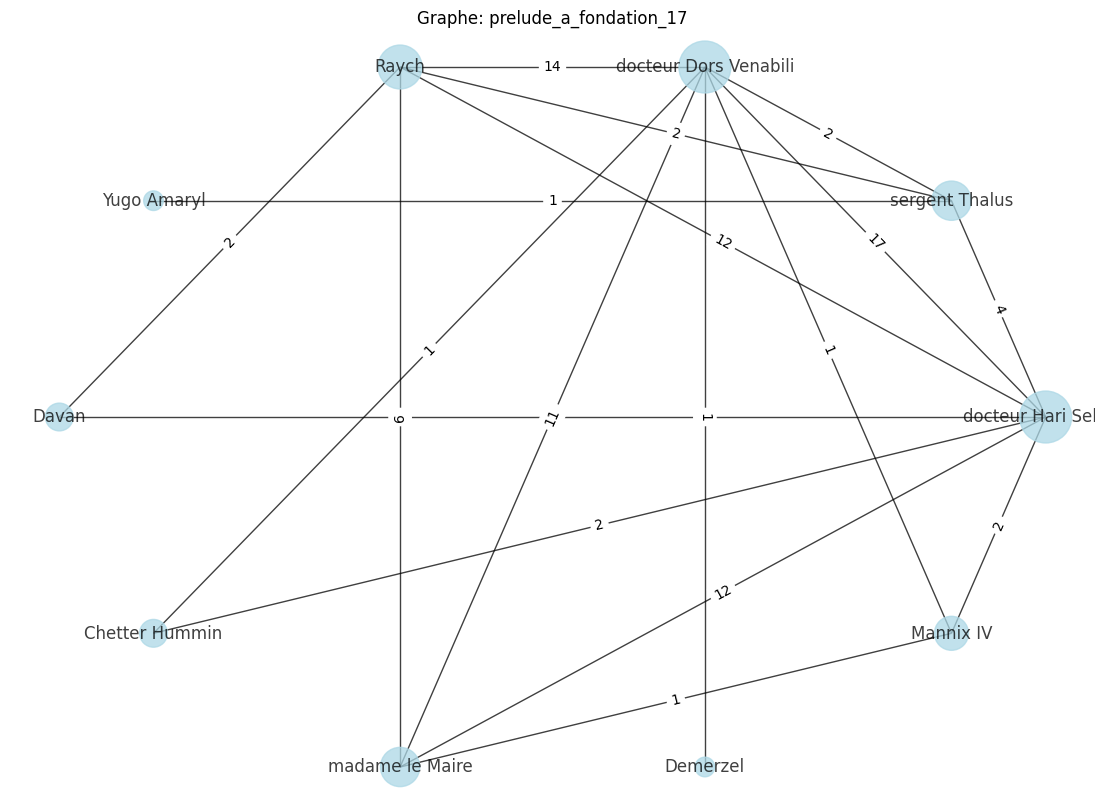

In [39]:
show_graph(graphs['prelude_a_fondation_17'], 'prelude_a_fondation_17')

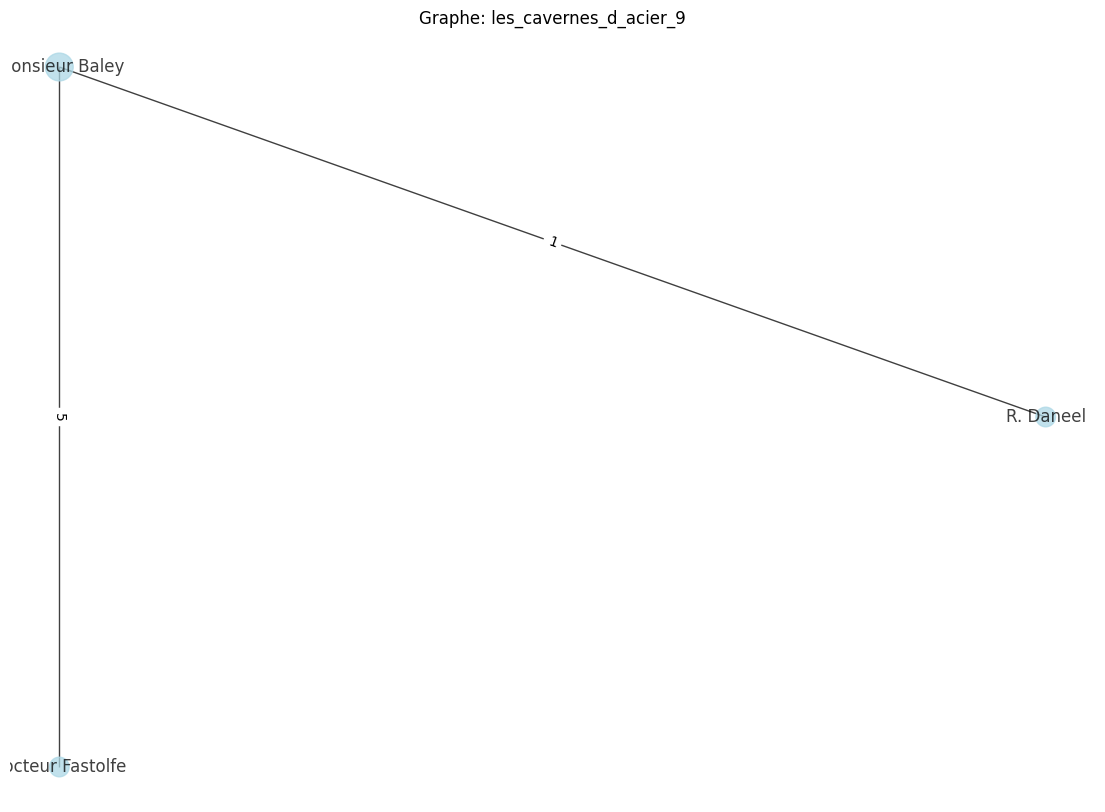

In [40]:
show_graph(graphs['les_cavernes_d_acier_9'], 'les_cavernes_d_acier_9')

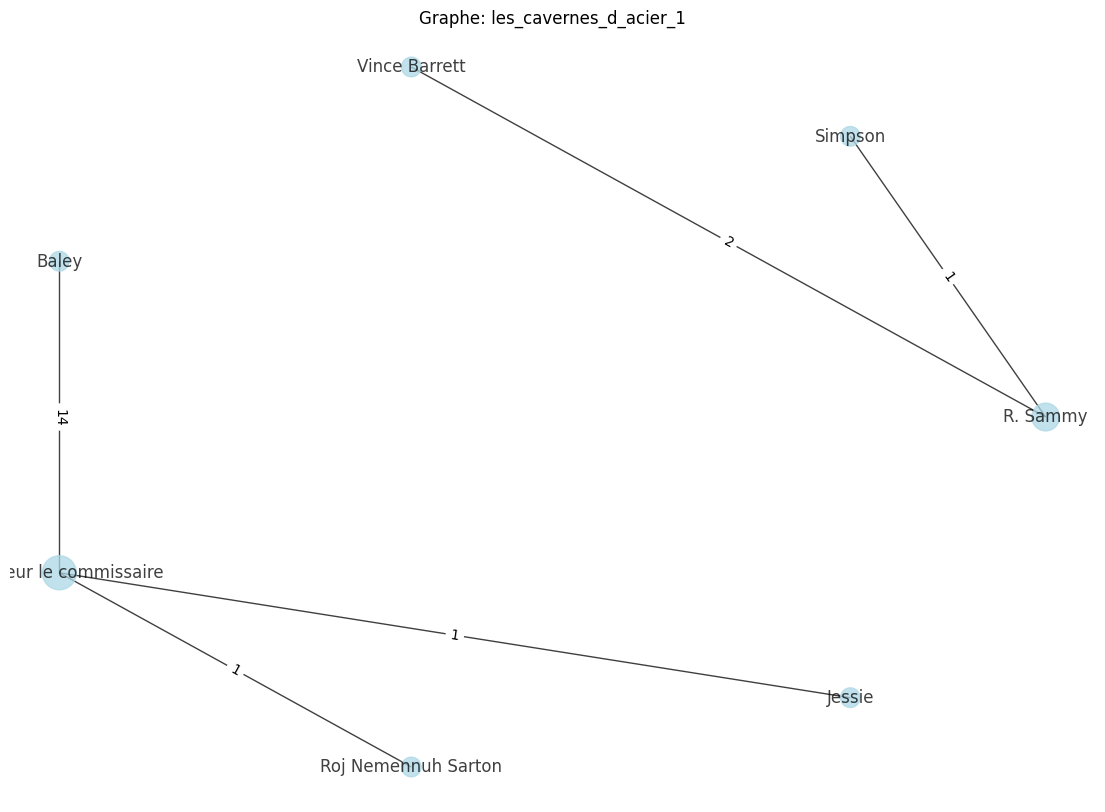

In [41]:
show_graph(graphs['les_cavernes_d_acier_1'], 'les_cavernes_d_acier_1')

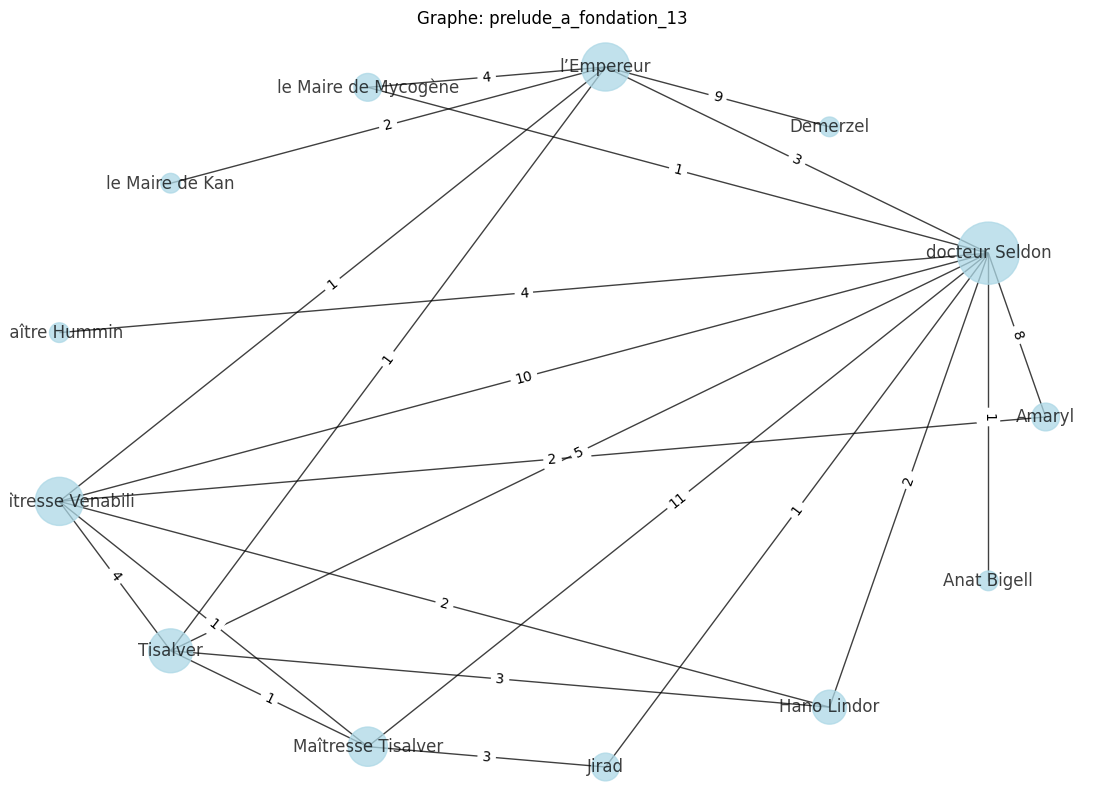

In [42]:
show_graph(graphs['prelude_a_fondation_13'], 'prelude_a_fondation_13')

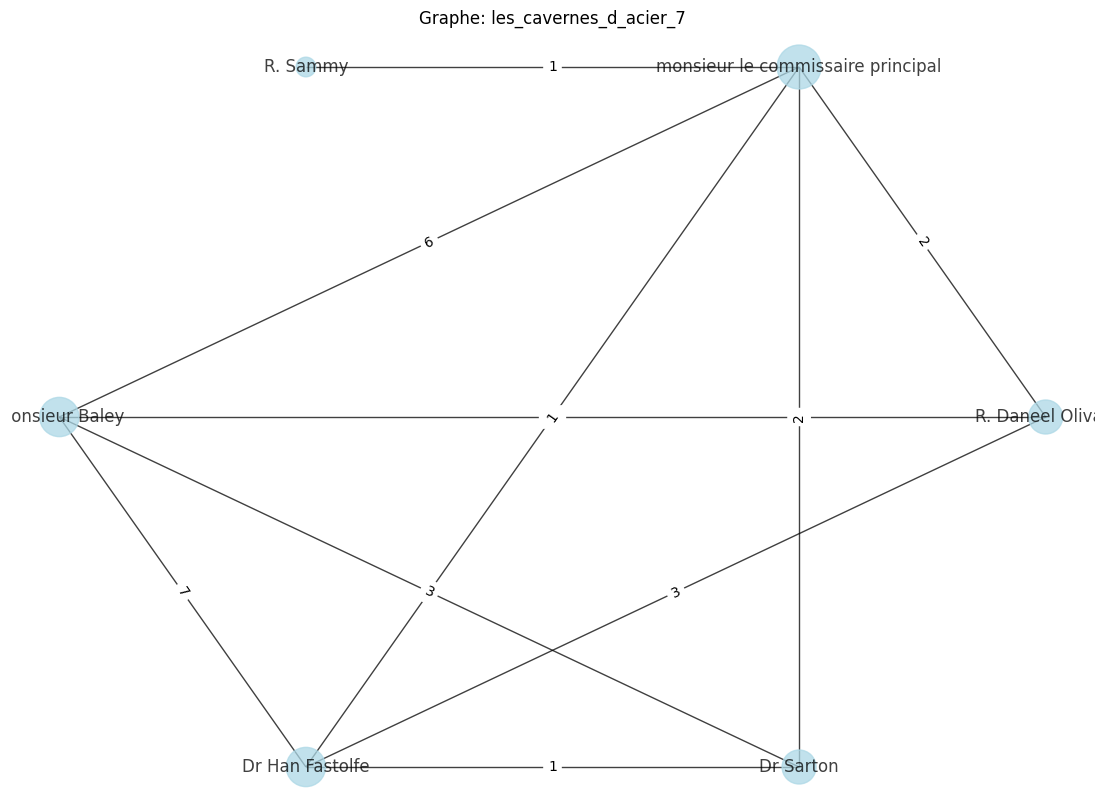

In [43]:
show_graph(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')

In [44]:
def plot_pagerank(graph, title):

    pagerank_scores = nx.pagerank(graph)
    characters = list(pagerank_scores.keys())
    scores = list(pagerank_scores.values())

    plt.bar(characters, scores, color='skyblue')
    plt.xlabel('Characters')
    plt.ylabel('PageRank Score')
    plt.title('PageRank Scores for Characters')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title(f'Graphe: {title}')
    plt.show()

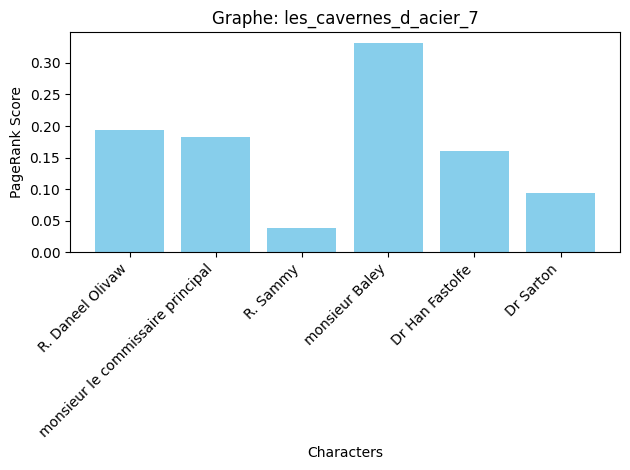

In [45]:
plot_pagerank(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')

In [46]:
def plot_eigenvector(graph, title):
    
    eigenvector_scores = nx.eigenvector_centrality(graph, weight='weight')
    characters = list(eigenvector_scores.keys())
    scores = list(eigenvector_scores.values())

    plt.bar(characters, scores, color='skyblue')
    plt.xlabel('Characters')
    plt.ylabel('Eigenvector Score')
    plt.title('Eigenvector Score for Characters')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.title(f'Graphe: {title}')
    plt.show()

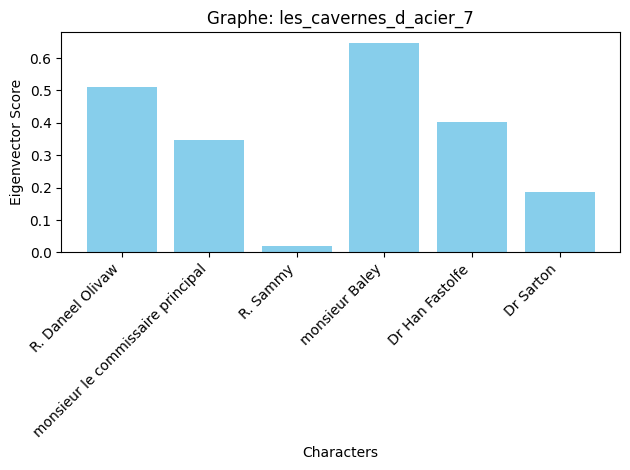

In [47]:
plot_eigenvector(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')

In [48]:
def plot_betweeness(graph, title):
    
    betweenness_scores = nx.betweenness_centrality(graph, weight='weight', seed=0)
    characters = list(betweenness_scores.keys())
    scores = list(betweenness_scores.values())

    plt.bar(characters, scores, color='skyblue')
    plt.xlabel('Characters')
    plt.ylabel('Betweenness Score')
    plt.title('Betweenness Score for Characters')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title(f'Graphe: {title}')
    plt.show()

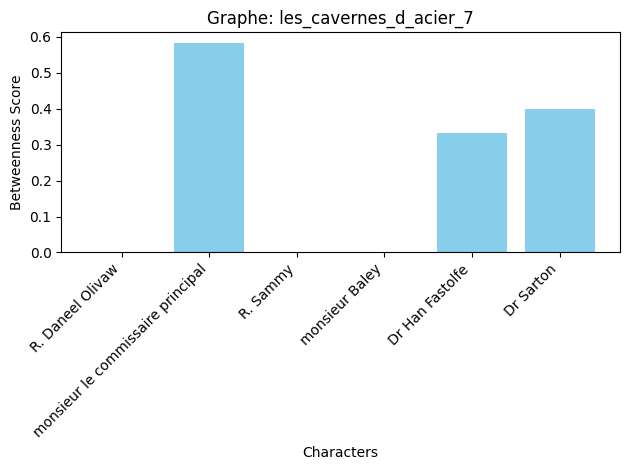

In [49]:
plot_betweeness(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')

In [50]:
def plot_degree(graph, title):
    
    degree_scores = dict(nx.degree(graph, weight='weight'))
    characters = list(degree_scores.keys())
    scores = list(degree_scores.values())

    plt.bar(characters, scores, color='skyblue')
    plt.xlabel('Characters')
    plt.ylabel('Degree Score')
    plt.title('Degree Score for Characters')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.title(f'Graphe: {title}')
    plt.show()

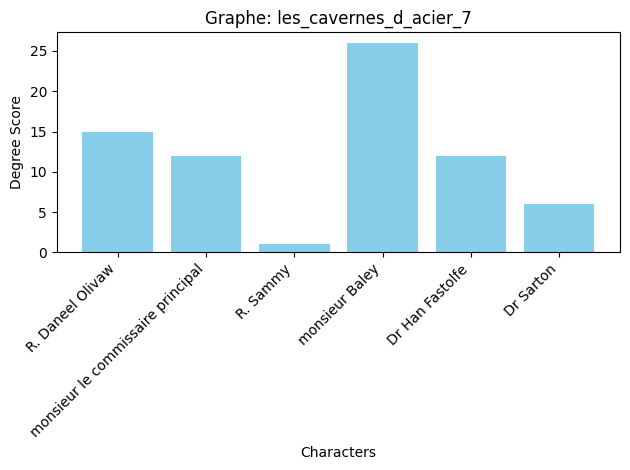

In [51]:
plot_degree(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')

In [52]:
def plot_closeness(graph, title):
    
    closeness_scores = nx.closeness_centrality(graph)
    characters = list(closeness_scores.keys())
    scores = list(closeness_scores.values())

    plt.bar(characters, scores, color='skyblue')
    plt.xlabel('Characters')
    plt.ylabel('Closeness Score')
    plt.title('Closeness Score for Characters')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.title(f'Graphe: {title}')
    plt.show()

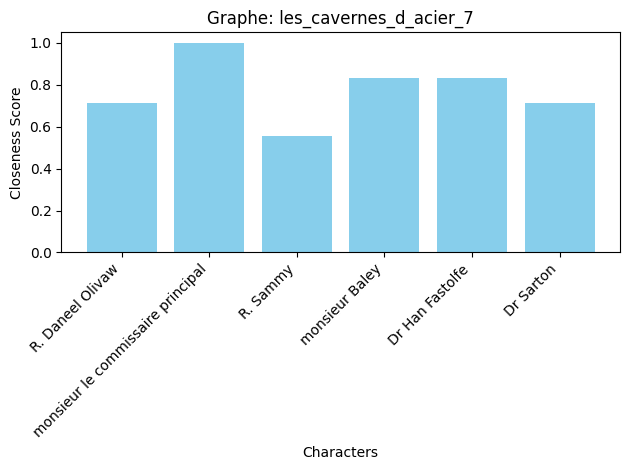

In [53]:
plot_closeness(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')

In [54]:
def show_community_graph(graph, title):
    partition = community.best_partition(graph)
    fig, ax = plt.subplots(figsize=(14, 10))
    pos = nx.circular_layout(graph, scale = 20)
    labels = nx.get_edge_attributes(graph, 'weight')
    d = dict(graph.degree)
    nx.draw(
        graph, 
        pos,
        node_color=list(partition.values()),
        alpha = 0.75,
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*200 for k in d],
        edgelist = labels,
        ax=ax
    )
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)
    plt.title(f'Graphe: {title}')
    plt.show()

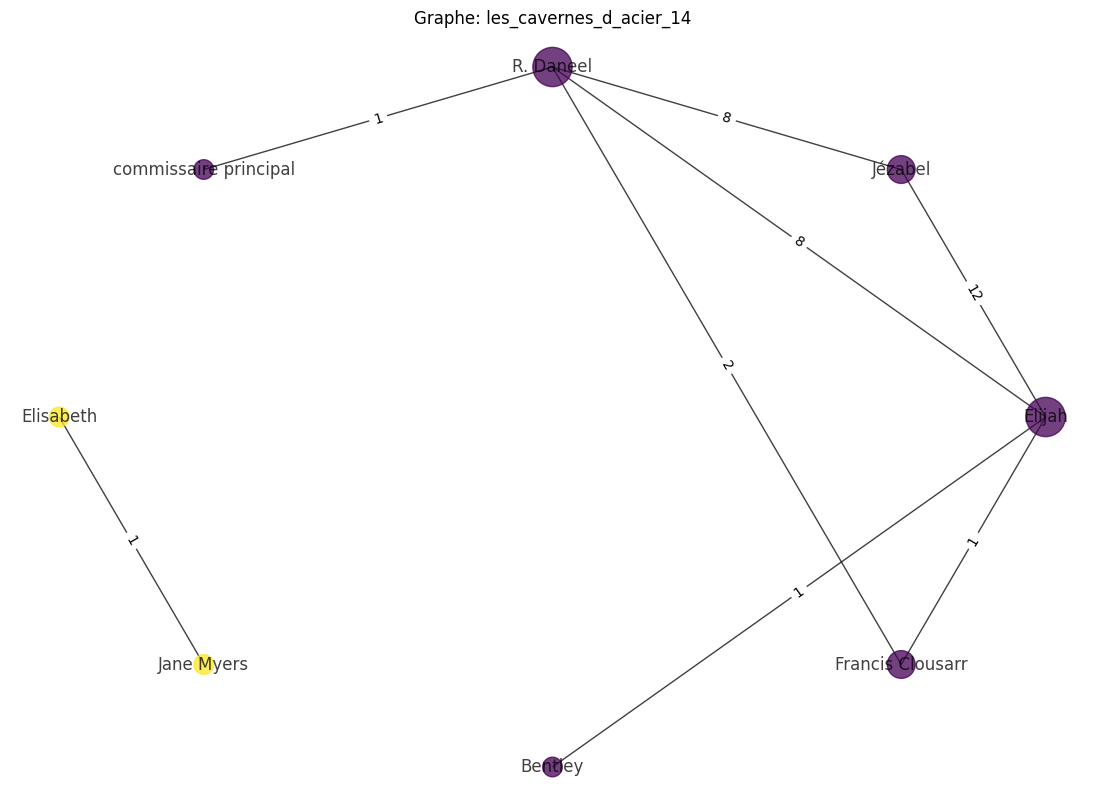

In [55]:
show_community_graph(graphs['les_cavernes_d_acier_14'], 'les_cavernes_d_acier_14')

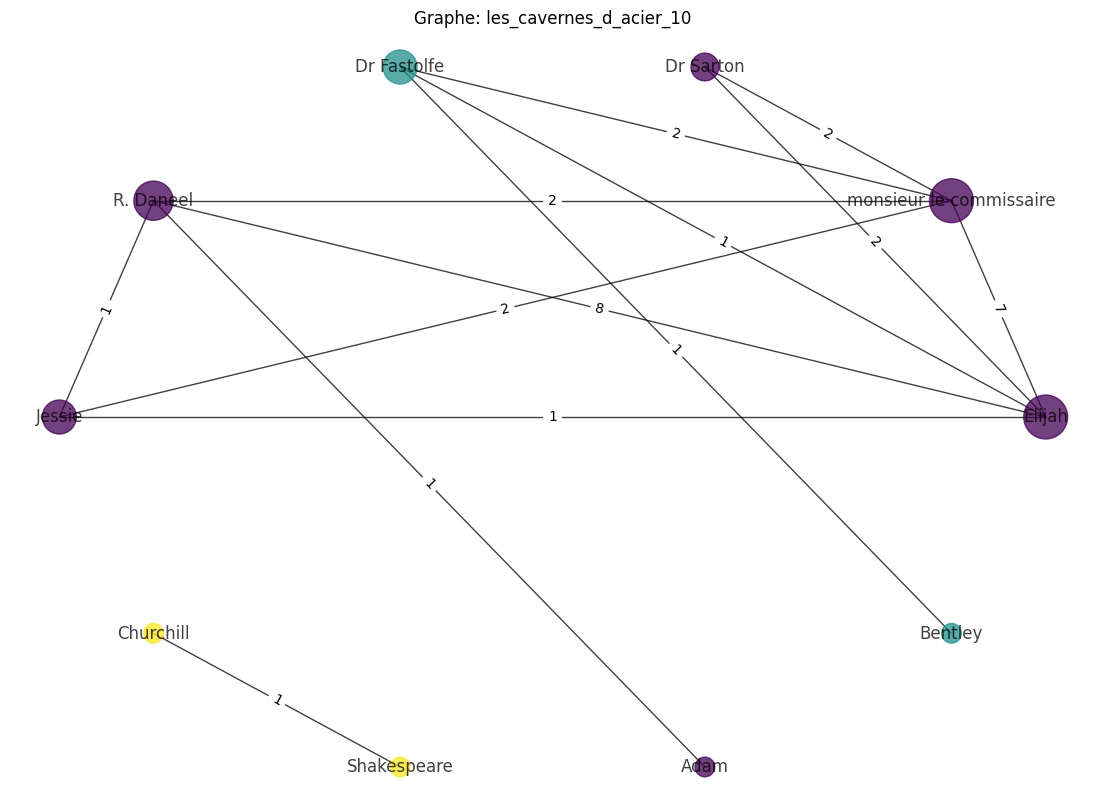

In [56]:
show_community_graph(graphs['les_cavernes_d_acier_10'], 'les_cavernes_d_acier_10')

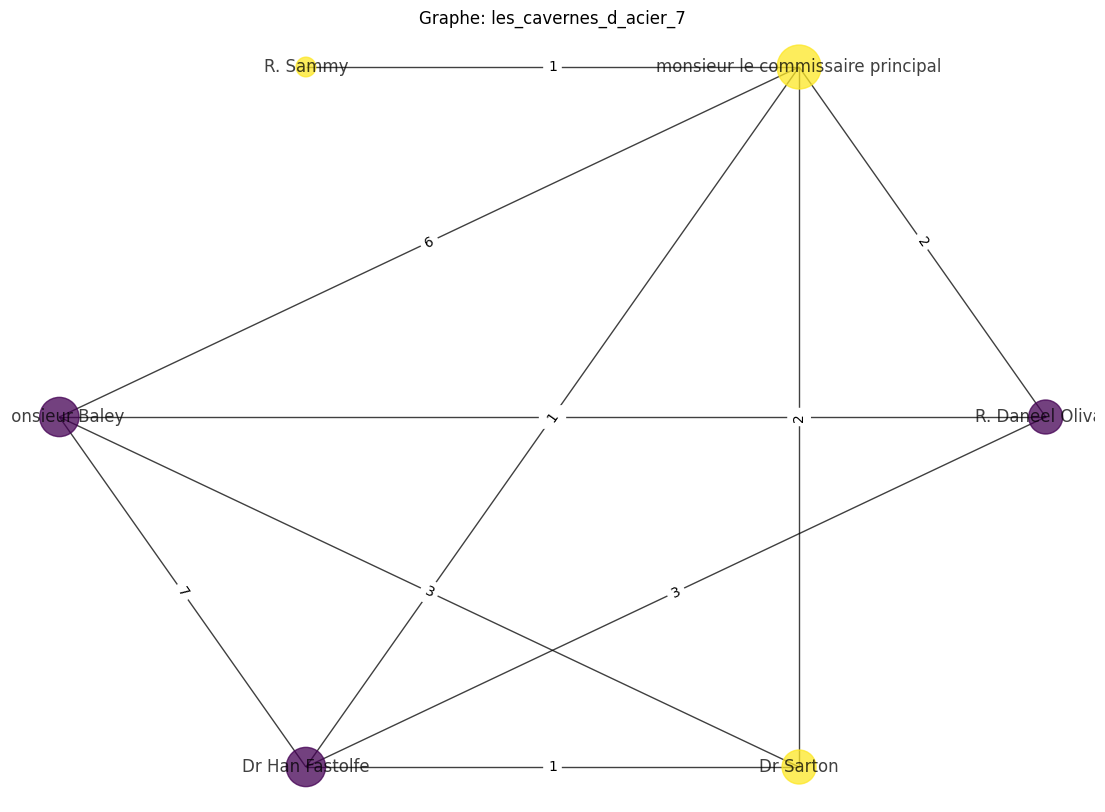

In [57]:
show_community_graph(graphs['les_cavernes_d_acier_7'], 'les_cavernes_d_acier_7')